# Setup

In [1]:
# Define Parameters
batch_size = 32
epochs = 5
task = 'Informativeness_Classification'

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import time
import torch
import torch.nn as nn
import torch.optim
import torchvision.models as models
import torchvision.transforms as transforms
import warnings
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

device = torch.device("cuda:0")
warnings.filterwarnings("ignore")

# Data Loading

In [3]:
if_train_path = 'C:/crisis_vision_benchmarks/tasks/informative/consolidated/consolidated_info_train_final.tsv'
if_test_path = 'C:/crisis_vision_benchmarks/tasks/informative/consolidated/consolidated_info_test_final.tsv'
if_dev_path = 'C:/crisis_vision_benchmarks/tasks/informative/consolidated/consolidated_info_dev_final.tsv'

train_label = pd.read_table(if_train_path)
test_label = pd.read_table(if_test_path)
dev_label = pd.read_table(if_dev_path)

print(train_label.shape)
print(test_label.shape)
print(dev_label.shape)

(48186, 4)
(8477, 4)
(3054, 4)


In [4]:
class_count = train_label['class_label'].value_counts()

for class_name, count in class_count.items():
    print("Class:", class_name)
    print("Count:", count)
    print("Percentage: {:.2f}%".format(count / len(train_label) * 100))
    print()

Class: informative
Count: 26486
Percentage: 54.97%

Class: not_informative
Count: 21700
Percentage: 45.03%



In [5]:
class_label_map = {"informative": 1, "not_informative": 0}

def get_data(pd_label, class_label_map):
    image_path = pd_label['image_path']
    class_label = pd_label['class_label']

    X, y = [], []

    tfms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    for i in tqdm(image_path):
        path = os.path.join('C:/crisis_vision_benchmarks/', i)
        img = cv2.imread(path)
        if img is None:
            print(f"Error reading image: {path}")
            continue
        img = cv2.resize(img, (224, 224))
        img = img.astype(np.float32) / 255.0
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = tfms(img) 
        X.append(img)

    print(X[0].shape)
    X = np.stack(X)
    print(X.shape)

    for label in tqdm(class_label):
        if label not in class_label_map:
            print(f"Error: Unknown class label: {label}")
            continue
        y.append(class_label_map[label])

    y = np.array(y, dtype=np.int64)
    print(y.shape)

    return X, y

In [ ]:
X_train, y_train = get_data(train_label, class_label_map)
X_test, y_test = get_data(test_label, class_label_map)
X_dev, y_dev = get_data(dev_label, class_label_map)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)
trainset = TensorDataset(X_train, y_train)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.int64)
testset = TensorDataset(X_test, y_test)

X_dev = torch.tensor(X_dev, dtype=torch.float32)
y_dev = torch.tensor(y_dev, dtype=torch.int64)
devset = TensorDataset(X_dev, y_dev)

In [ ]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)
devloader = DataLoader(devset, batch_size=batch_size, shuffle=True, num_workers=4)

# ResNet50_pretrained

In [ ]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_label_map))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
criterion = nn.CrossEntropyLoss()

train_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}

## Train

In [ ]:
# Learning schedule update
def dev_one_epoch(dev_data_loader):
    epoch_loss = []
    epoch_acc = []

    model.eval()

    with torch.no_grad():
        for images, labels in dev_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)  # Forward

            # Calculating Loss
            _loss = criterion(preds, labels)
            loss = _loss.item()
            epoch_loss.append(loss)

            # Calculating Accuracy
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            epoch_acc.append(acc)

    # Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)

    return epoch_loss, epoch_acc

In [ ]:
def train_one_epoch(train_data_loader):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.train()

    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(images)

        # Calculating Loss
        loss = criterion(preds, labels)
        epoch_loss.append(loss.item())

        # Calculating Metrics
        _, predicts = preds.max(1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)
        f1 = f1_score(labels, predicts, average="weighted")
        epoch_acc.append(acc)
        epoch_f1.append(f1)
        trues.append(labels)
        prediction.append(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(accuracy)
    train_logs["acc"].append(epoch_acc) # check
    train_logs["f1"].append(epoch_f1) # check
    train_logs["f1-score"].append(f1score)
    train_logs["time"].append(total_time)

    return epoch_loss, accuracy, f1score, total_time

def val_one_epoch(val_data_loader, best_val_acc):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculating Metrics
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            f1 = f1_score(labels, predicts, average="weighted")
            epoch_acc.append(acc)
            epoch_f1.append(f1)
            trues.append(labels)
            prediction.append(predicts)
   
    
    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    cm = confusion_matrix(trues, prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100
    cr = classification_report(trues, prediction)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(accuracy)
    val_logs["acc"].append(epoch_acc) # check
    val_logs["f1"].append(epoch_f1) # check
    val_logs["f1-score"].append(f1score)
    val_logs["time"].append(total_time)

    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), task + "_ResNet50_pretrained.pth")

    return epoch_loss, accuracy, f1score, total_time, best_val_acc, cm, cr

In [ ]:
best_val_acc = 0
best_val_f1 = 0

for epoch in range(epochs):
    train_loss, train_acc, train_f1, train_time = train_one_epoch(trainloader) # Training
    dev_loss, dev_acc = dev_one_epoch(devloader) # Dev
    lr_scheduler.step(dev_loss)
    val_loss, val_acc, val_f1, val_time, best_val_acc, cm, cr = val_one_epoch(testloader, best_val_acc) # Validation

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1

    total_time = train_time + val_time
    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.2f}% - time: {total_time:.2f}s")
    print(lr_scheduler)

Epoch 1/5 - loss: 1.0048 - accuracy: 61.34% - val_loss: 0.7538 - val_accuracy: 71.39% - time: 136.53s
Epoch 2/5 - loss: 0.6616 - accuracy: 74.79% - val_loss: 0.6380 - val_accuracy: 75.19% - time: 89.01s
Epoch 3/5 - loss: 0.5334 - accuracy: 78.97% - val_loss: 0.6042 - val_accuracy: 76.35% - time: 89.13s
Epoch 4/5 - loss: 0.4327 - accuracy: 83.40% - val_loss: 0.5973 - val_accuracy: 76.15% - time: 89.98s
Epoch 5/5 - loss: 0.3392 - accuracy: 87.62% - val_loss: 0.6100 - val_accuracy: 76.63% - time: 90.40s


In [ ]:
print(task + '_ResNet50_pretrained Performance:')
print(f'Accuracy : {best_val_acc:.2f}%')
print(f'F1-Score : {best_val_f1:.2f}%')
print(task + '_ResNet50_pretrained Classification Report:')
print(cr)

Humanitarian_Classification_ResNet50_pretrained Performance:
Accuracy : 76.80%
F1-Score : 75.89%
Humanitarian_Classification_ResNet50_pretrained Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.89      0.85      1550
           1       0.76      0.71      0.73       821
           2       0.63      0.59      0.61       391
           3       0.61      0.33      0.43       160

    accuracy                           0.77      2922
   macro avg       0.70      0.63      0.65      2922
weighted avg       0.76      0.77      0.76      2922



## Visualize Results & Confusion Matrix

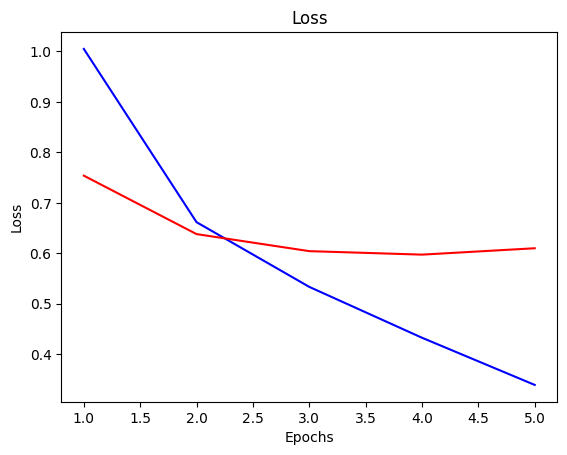

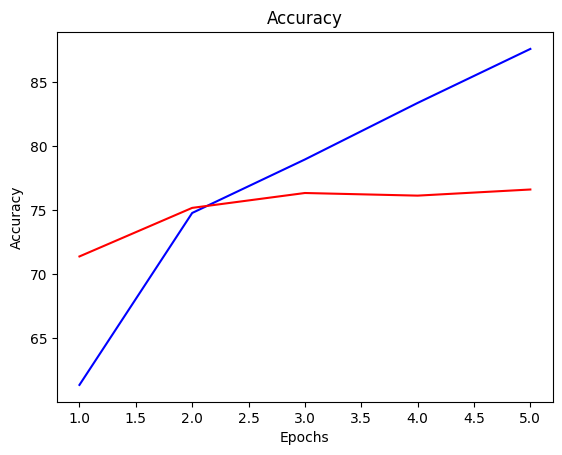

In [ ]:
# Loss
plt.title("Loss")
plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Humanitarian_Classification_ResNet50_pretrained Confusion Matrix:

affected_injured_or_dead_people: 3, rescue_volunteering_or_donation_effort: 2, infrastructure_and_utility_damage: 1, not_humanitarian: 0


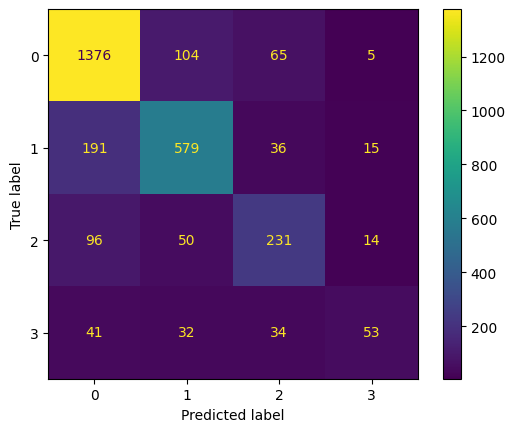

In [14]:
# "informative": 1, "not_informative": 0
print(task + '_ResNet50_pretrained Confusion Matrix:\n')
print('informative: 1, not_informative: 0')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()

# ResNet50_Scratch

In [15]:
model = models.resnet50(weights=None)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_label_map))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
criterion = nn.CrossEntropyLoss()

train_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}

## Train

In [16]:
# Learning schedule update
def dev_one_epoch(dev_data_loader):
    epoch_loss = []
    epoch_acc = []

    model.eval()

    with torch.no_grad():
        for images, labels in dev_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)  # Forward

            # Calculating Loss
            _loss = criterion(preds, labels)
            loss = _loss.item()
            epoch_loss.append(loss)

            # Calculating Accuracy
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            epoch_acc.append(acc)

    # Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)

    return epoch_loss, epoch_acc

In [17]:
def train_one_epoch(train_data_loader):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.train()

    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(images)

        # Calculating Loss
        loss = criterion(preds, labels)
        epoch_loss.append(loss.item())

        # Calculating Metrics
        _, predicts = preds.max(1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)
        f1 = f1_score(labels, predicts, average="weighted")
        epoch_acc.append(acc)
        epoch_f1.append(f1)
        trues.append(labels)
        prediction.append(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(accuracy)
    train_logs["acc"].append(epoch_acc) # check
    train_logs["f1"].append(epoch_f1) # check
    train_logs["f1-score"].append(f1score)
    train_logs["time"].append(total_time)

    return epoch_loss, accuracy, f1score, total_time

def val_one_epoch(val_data_loader, best_val_acc):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculating Metrics
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            f1 = f1_score(labels, predicts, average="weighted")
            epoch_acc.append(acc)
            epoch_f1.append(f1)
            trues.append(labels)
            prediction.append(predicts)
   
    
    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    cm = confusion_matrix(trues, prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100
    cr = classification_report(trues, prediction)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(accuracy)
    val_logs["acc"].append(epoch_acc) # check
    val_logs["f1"].append(epoch_f1) # check
    val_logs["f1-score"].append(f1score)
    val_logs["time"].append(total_time)

    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), task + "_ResNet50_scratch.pth")

    return epoch_loss, accuracy, f1score, total_time, best_val_acc, cm, cr

In [18]:
best_val_acc = 0
best_val_f1 = 0

for epoch in range(epochs):
    train_loss, train_acc, train_f1, train_time = train_one_epoch(trainloader) # Training
    dev_loss, dev_acc = dev_one_epoch(devloader) # Dev
    lr_scheduler.step(dev_loss)
    val_loss, val_acc, val_f1, val_time, best_val_acc, cm, cr = val_one_epoch(testloader, best_val_acc) # Validation

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1

    total_time = train_time + val_time
    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.2f}% - time: {total_time:.2f}s")

Epoch 1/5 - loss: 1.1222 - accuracy: 50.59% - val_loss: 1.0594 - val_accuracy: 55.37% - time: 90.26s
Epoch 2/5 - loss: 1.0669 - accuracy: 55.08% - val_loss: 1.0312 - val_accuracy: 57.70% - time: 90.62s
Epoch 3/5 - loss: 1.0412 - accuracy: 57.09% - val_loss: 1.0394 - val_accuracy: 57.94% - time: 90.93s
Epoch 4/5 - loss: 1.0245 - accuracy: 57.53% - val_loss: 1.0291 - val_accuracy: 58.18% - time: 91.03s
Epoch 5/5 - loss: 1.0103 - accuracy: 58.42% - val_loss: 1.0125 - val_accuracy: 58.08% - time: 90.98s


In [19]:
print(task + '_ResNet50_scratch Performance:')
print(f'Accuracy : {best_val_acc:.2f}%')
print(f'F1-Score : {best_val_f1:.2f}%')
print(task + '_ResNet50_scratch Classification Report:')
print(cr)

Humanitarian_Classification_ResNet50_scratch Performance:
Accuracy : 58.42%
F1-Score : 52.62%
Humanitarian_Classification_ResNet50_scratch Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.74      0.70      1550
           1       0.47      0.67      0.55       821
           2       0.10      0.00      0.00       391
           3       0.00      0.00      0.00       160

    accuracy                           0.58      2922
   macro avg       0.31      0.35      0.31      2922
weighted avg       0.50      0.58      0.53      2922



## Visualize Results & Confusion Matrix

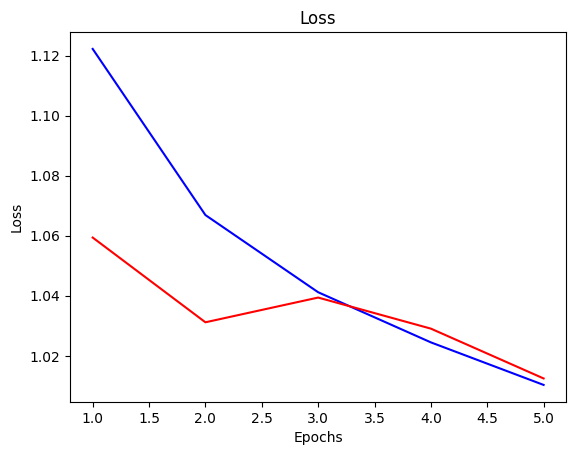

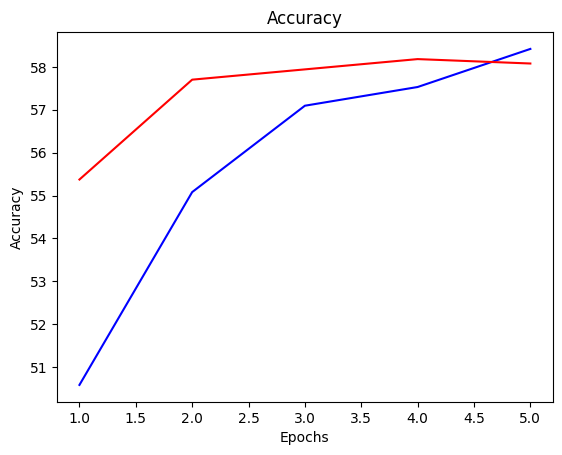

In [20]:
# Loss
plt.title("Loss")
plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Humanitarian_Classification_ResNet50_scratch Confusion Matrix:

affected_injured_or_dead_people: 3, rescue_volunteering_or_donation_effort: 2, infrastructure_and_utility_damage: 1, not_humanitarian: 0


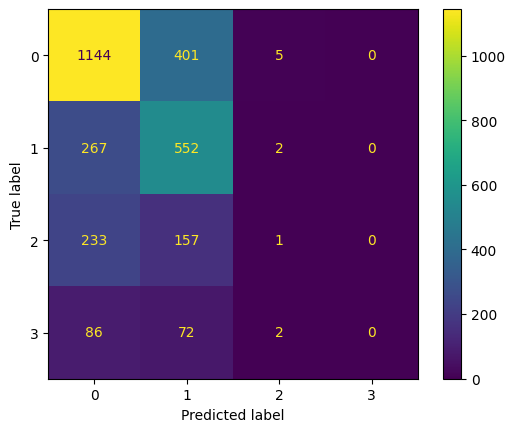

In [21]:
# "informative": 1, "not_informative": 0
print(task + '_ResNet50_scratch Confusion Matrix:\n')
print('informative: 1, not_informative: 0')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()

# EfficientNetb1_pretrained

In [22]:
model = models.efficientnet_b1(weights=models.EfficientNet_B1_Weights.DEFAULT)
num_ftrs = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(num_ftrs, len(class_label_map))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
criterion = nn.CrossEntropyLoss()

train_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}

## Train

In [23]:
# Learning schedule update
def dev_one_epoch(dev_data_loader):
    epoch_loss = []
    epoch_acc = []

    model.eval()

    with torch.no_grad():
        for images, labels in dev_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)  # Forward

            # Calculating Loss
            _loss = criterion(preds, labels)
            loss = _loss.item()
            epoch_loss.append(loss)

            # Calculating Accuracy
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            epoch_acc.append(acc)

    # Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)

    return epoch_loss, epoch_acc

In [24]:
def train_one_epoch(train_data_loader):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.train()

    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(images)

        # Calculating Loss
        loss = criterion(preds, labels)
        epoch_loss.append(loss.item())

        # Calculating Metrics
        _, predicts = preds.max(1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)
        f1 = f1_score(labels, predicts, average="weighted")
        epoch_acc.append(acc)
        epoch_f1.append(f1)
        trues.append(labels)
        prediction.append(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(accuracy)
    train_logs["acc"].append(epoch_acc) # check
    train_logs["f1"].append(epoch_f1) # check
    train_logs["f1-score"].append(f1score)
    train_logs["time"].append(total_time)

    return epoch_loss, accuracy, f1score, total_time

def val_one_epoch(val_data_loader, best_val_acc):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculating Metrics
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            f1 = f1_score(labels, predicts, average="weighted")
            epoch_acc.append(acc)
            epoch_f1.append(f1)
            trues.append(labels)
            prediction.append(predicts)
   
    
    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    cm = confusion_matrix(trues, prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100
    cr = classification_report(trues, prediction)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(accuracy)
    val_logs["acc"].append(epoch_acc) # check
    val_logs["f1"].append(epoch_f1) # check
    val_logs["f1-score"].append(f1score)
    val_logs["time"].append(total_time)

    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), task + "_EfficientNetb1_pretrained.pth")

    return epoch_loss, accuracy, f1score, total_time, best_val_acc, cm, cr

In [25]:
best_val_acc = 0
best_val_f1 = 0

for epoch in range(epochs):
    train_loss, train_acc, train_f1, train_time = train_one_epoch(trainloader) # Training
    dev_loss, dev_acc = dev_one_epoch(devloader) # Dev
    lr_scheduler.step(dev_loss)
    val_loss, val_acc, val_f1, val_time, best_val_acc, cm, cr = val_one_epoch(testloader, best_val_acc) # Validation

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1

    total_time = train_time + val_time
    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.2f}% - time: {total_time:.2f}s")

Epoch 1/5 - loss: 1.1968 - accuracy: 55.18% - val_loss: 0.9994 - val_accuracy: 65.67% - time: 77.02s
Epoch 2/5 - loss: 0.9104 - accuracy: 66.29% - val_loss: 0.8098 - val_accuracy: 69.51% - time: 76.81s
Epoch 3/5 - loss: 0.7845 - accuracy: 69.84% - val_loss: 0.7410 - val_accuracy: 70.94% - time: 76.64s
Epoch 4/5 - loss: 0.7240 - accuracy: 71.94% - val_loss: 0.6828 - val_accuracy: 72.11% - time: 77.19s
Epoch 5/5 - loss: 0.6835 - accuracy: 73.16% - val_loss: 0.6609 - val_accuracy: 73.20% - time: 77.69s


In [26]:
print(task + '_EfficientNetb1_pretrained Performance:')
print(f'Accuracy : {best_val_acc:.2f}%')
print(f'F1-Score : {best_val_f1:.2f}%')
print(task + '_EfficientNetb1_pretrained Classification Report:')
print(cr)

Humanitarian_Classification_EfficientNetb1_pretrained Performance:
Accuracy : 73.40%
F1-Score : 71.67%
Humanitarian_Classification_EfficientNetb1_pretrained Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.82      0.81      1550
           1       0.70      0.80      0.75       821
           2       0.51      0.51      0.51       391
           3       0.75      0.07      0.14       160

    accuracy                           0.73      2922
   macro avg       0.69      0.55      0.55      2922
weighted avg       0.73      0.73      0.72      2922



## Visualize Results & Confusion Matrix

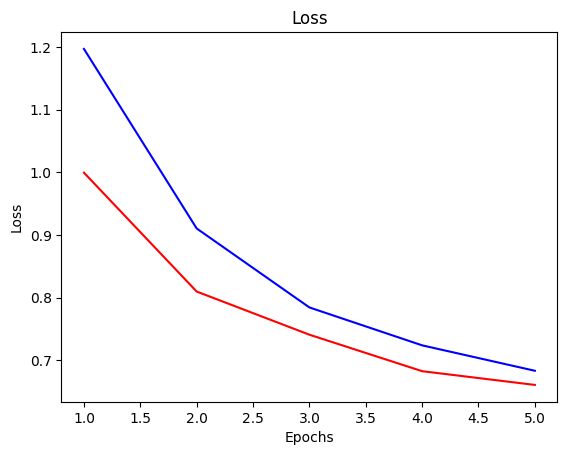

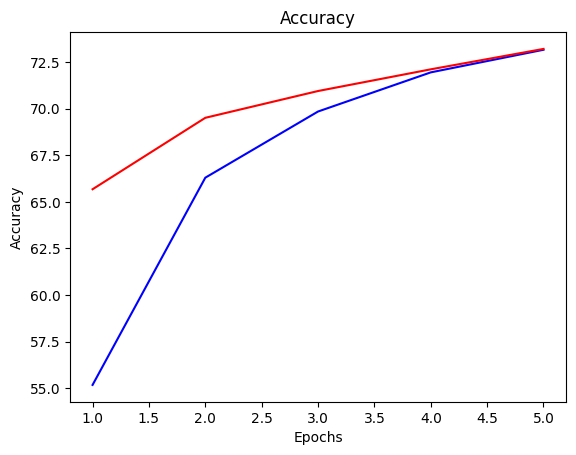

In [27]:
# Loss
plt.title("Loss")
plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Humanitarian_Classification_EfficientNetb1_pretrained Confusion Matrix:

affected_injured_or_dead_people: 3, rescue_volunteering_or_donation_effort: 2, infrastructure_and_utility_damage: 1, not_humanitarian: 0


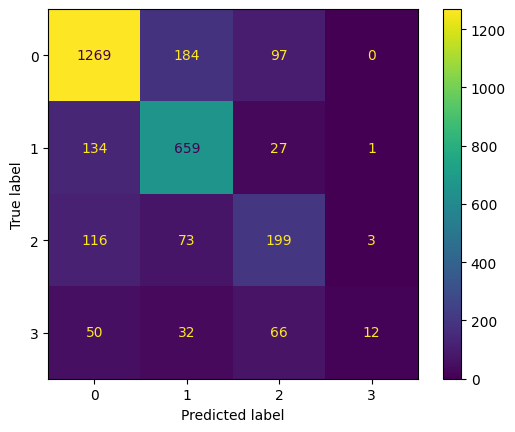

In [28]:
# "informative": 1, "not_informative": 0
print(task + '_EfficientNetb1_pretrained Confusion Matrix:\n')
print('informative: 1, not_informative: 0')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()

# EfficientNetb1_scratch

In [29]:
model = models.efficientnet_b1(weights=None)
num_ftrs = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(num_ftrs, len(class_label_map))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
criterion = nn.CrossEntropyLoss()

train_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}

## Train

In [30]:
# Learning schedule update
def dev_one_epoch(dev_data_loader):
    epoch_loss = []
    epoch_acc = []

    model.eval()

    with torch.no_grad():
        for images, labels in dev_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)  # Forward

            # Calculating Loss
            _loss = criterion(preds, labels)
            loss = _loss.item()
            epoch_loss.append(loss)

            # Calculating Accuracy
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            epoch_acc.append(acc)

    # Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)

    return epoch_loss, epoch_acc

In [31]:
def train_one_epoch(train_data_loader):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.train()

    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(images)

        # Calculating Loss
        loss = criterion(preds, labels)
        epoch_loss.append(loss.item())

        # Calculating Metrics
        _, predicts = preds.max(1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)
        f1 = f1_score(labels, predicts, average="weighted")
        epoch_acc.append(acc)
        epoch_f1.append(f1)
        trues.append(labels)
        prediction.append(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(accuracy)
    train_logs["acc"].append(epoch_acc) # check
    train_logs["f1"].append(epoch_f1) # check
    train_logs["f1-score"].append(f1score)
    train_logs["time"].append(total_time)

    return epoch_loss, accuracy, f1score, total_time

def val_one_epoch(val_data_loader, best_val_acc):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculating Metrics
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            f1 = f1_score(labels, predicts, average="weighted")
            epoch_acc.append(acc)
            epoch_f1.append(f1)
            trues.append(labels)
            prediction.append(predicts)
   
    
    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    cm = confusion_matrix(trues, prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100
    cr = classification_report(trues, prediction)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(accuracy)
    val_logs["acc"].append(epoch_acc) # check
    val_logs["f1"].append(epoch_f1) # check
    val_logs["f1-score"].append(f1score)
    val_logs["time"].append(total_time)

    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), task + "_EfficientNetb1_scratch.pth")

    return epoch_loss, accuracy, f1score, total_time, best_val_acc, cm, cr

In [32]:
best_val_acc = 0
best_val_f1 = 0

for epoch in range(epochs):
    train_loss, train_acc, train_f1, train_time = train_one_epoch(trainloader) # Training
    dev_loss, dev_acc = dev_one_epoch(devloader) # Dev
    lr_scheduler.step(dev_loss)
    val_loss, val_acc, val_f1, val_time, best_val_acc, cm, cr = val_one_epoch(testloader, best_val_acc) # Validation

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1

    total_time = train_time + val_time
    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.2f}% - time: {total_time:.2f}s")

Epoch 1/5 - loss: 1.3207 - accuracy: 39.69% - val_loss: 1.2884 - val_accuracy: 33.64% - time: 78.12s
Epoch 2/5 - loss: 1.2008 - accuracy: 45.04% - val_loss: 1.1824 - val_accuracy: 40.31% - time: 79.01s
Epoch 3/5 - loss: 1.1502 - accuracy: 49.04% - val_loss: 1.1335 - val_accuracy: 50.92% - time: 77.90s
Epoch 4/5 - loss: 1.1210 - accuracy: 51.16% - val_loss: 1.1207 - val_accuracy: 50.99% - time: 77.26s
Epoch 5/5 - loss: 1.1024 - accuracy: 52.80% - val_loss: 1.0895 - val_accuracy: 53.87% - time: 77.92s


In [33]:
print(task + '_EfficientNetb1_scratch Performance:')
print(f'Accuracy : {best_val_acc:.2f}%')
print(f'F1-Score : {best_val_f1:.2f}%')
print(task + '_EfficientNetb1_scratch Classification Report:')
print(cr)

Humanitarian_Classification_EfficientNetb1_scratch Performance:
Accuracy : 53.91%
F1-Score : 49.31%
Humanitarian_Classification_EfficientNetb1_scratch Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.66      0.67      1550
           1       0.39      0.68      0.50       821
           2       0.00      0.00      0.00       391
           3       0.00      0.00      0.00       160

    accuracy                           0.54      2922
   macro avg       0.27      0.33      0.29      2922
weighted avg       0.47      0.54      0.49      2922



## Visualize Results & Confusion Matrix

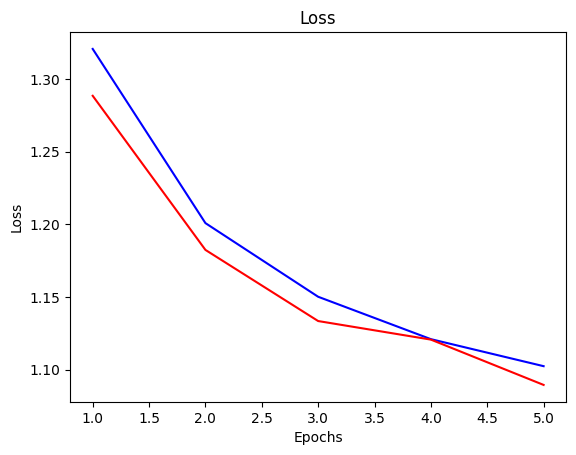

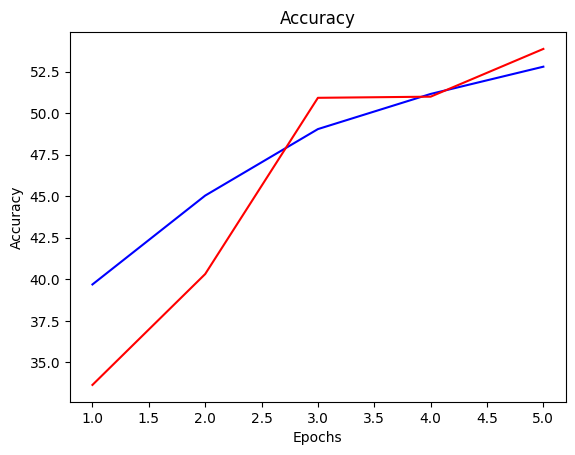

In [34]:
# Loss
plt.title("Loss")
plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Humanitarian_Classification_EfficientNetb1_scratch Confusion Matrix:

affected_injured_or_dead_people: 3, rescue_volunteering_or_donation_effort: 2, infrastructure_and_utility_damage: 1, not_humanitarian: 0


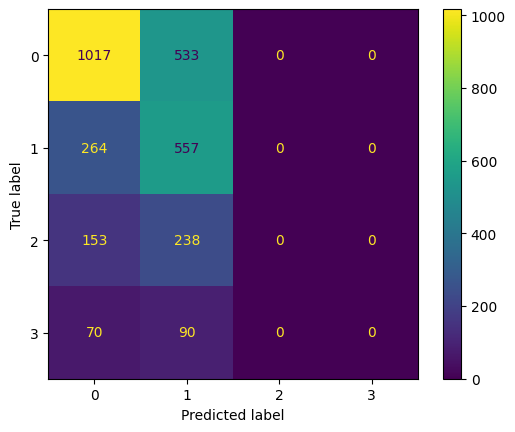

In [35]:
# "informative": 1, "not_informative": 0
print(task + '_EfficientNetb1_scratch Confusion Matrix:\n')
print('informative: 1, not_informative: 0')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()

# VGG16_pretrained

In [36]:
model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, len(class_label_map))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
criterion = nn.CrossEntropyLoss()

train_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}

## Train

In [37]:
# Learning schedule update
def dev_one_epoch(dev_data_loader):
    epoch_loss = []
    epoch_acc = []

    model.eval()

    with torch.no_grad():
        for images, labels in dev_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)  # Forward

            # Calculating Loss
            _loss = criterion(preds, labels)
            loss = _loss.item()
            epoch_loss.append(loss)

            # Calculating Accuracy
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            epoch_acc.append(acc)

    # Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)

    return epoch_loss, epoch_acc

In [38]:
def train_one_epoch(train_data_loader):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.train()

    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(images)

        # Calculating Loss
        loss = criterion(preds, labels)
        epoch_loss.append(loss.item())

        # Calculating Metrics
        _, predicts = preds.max(1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)
        f1 = f1_score(labels, predicts, average="weighted")
        epoch_acc.append(acc)
        epoch_f1.append(f1)
        trues.append(labels)
        prediction.append(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(accuracy)
    train_logs["acc"].append(epoch_acc) # check
    train_logs["f1"].append(epoch_f1) # check
    train_logs["f1-score"].append(f1score)
    train_logs["time"].append(total_time)

    return epoch_loss, accuracy, f1score, total_time

def val_one_epoch(val_data_loader, best_val_acc):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculating Metrics
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            f1 = f1_score(labels, predicts, average="weighted")
            epoch_acc.append(acc)
            epoch_f1.append(f1)
            trues.append(labels)
            prediction.append(predicts)
   
    
    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    cm = confusion_matrix(trues, prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100
    cr = classification_report(trues, prediction)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(accuracy)
    val_logs["acc"].append(epoch_acc) # check
    val_logs["f1"].append(epoch_f1) # check
    val_logs["f1-score"].append(f1score)
    val_logs["time"].append(total_time)

    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), task + "_VGG16_pretrained.pth")

    return epoch_loss, accuracy, f1score, total_time, best_val_acc, cm, cr

In [39]:
best_val_acc = 0
best_val_f1 = 0

for epoch in range(epochs):
    train_loss, train_acc, train_f1, train_time = train_one_epoch(trainloader) # Training
    dev_loss, dev_acc = dev_one_epoch(devloader) # Dev
    lr_scheduler.step(dev_loss)
    val_loss, val_acc, val_f1, val_time, best_val_acc, cm, cr = val_one_epoch(testloader, best_val_acc) # Validation

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1

    total_time = train_time + val_time
    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.2f}% - time: {total_time:.2f}s")

Epoch 1/5 - loss: 0.7937 - accuracy: 67.77% - val_loss: 0.6555 - val_accuracy: 72.52% - time: 180.04s
Epoch 2/5 - loss: 0.5708 - accuracy: 77.23% - val_loss: 0.6156 - val_accuracy: 74.16% - time: 178.94s
Epoch 3/5 - loss: 0.4441 - accuracy: 82.68% - val_loss: 0.6232 - val_accuracy: 74.61% - time: 180.43s
Epoch 4/5 - loss: 0.3310 - accuracy: 87.48% - val_loss: 0.6638 - val_accuracy: 74.02% - time: 180.47s
Epoch 5/5 - loss: 0.2165 - accuracy: 92.49% - val_loss: 0.7523 - val_accuracy: 75.02% - time: 179.10s


In [40]:
print(task + '_VGG16_pretrained Performance:')
print(f'Accuracy : {best_val_acc:.2f}%')
print(f'F1-Score : {best_val_f1:.2f}%')
print(task + '_VGG16_pretrained Classification Report:')
print(cr)

Humanitarian_Classification_VGG16_pretrained Performance:
Accuracy : 75.20%
F1-Score : 74.66%
Humanitarian_Classification_VGG16_pretrained Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1550
           1       0.72      0.77      0.74       821
           2       0.60      0.57      0.59       391
           3       0.51      0.34      0.41       160

    accuracy                           0.75      2922
   macro avg       0.66      0.63      0.64      2922
weighted avg       0.75      0.75      0.75      2922



## Visualize Results & Confusion Matrix

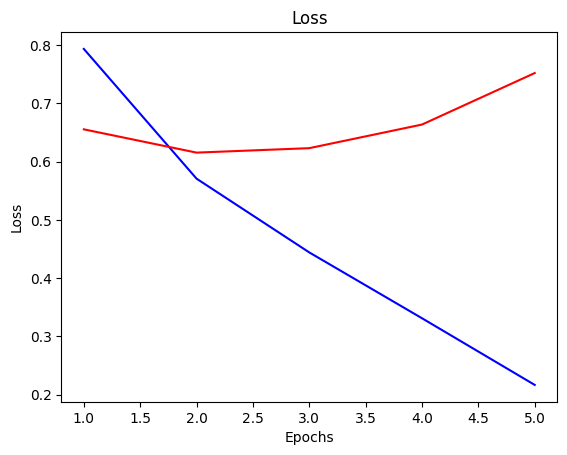

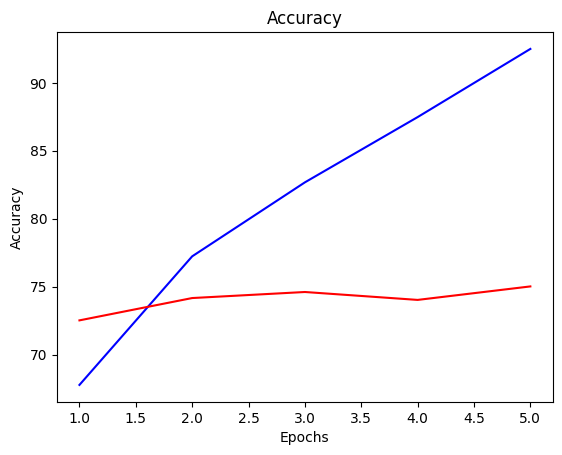

In [41]:
# Loss
plt.title("Loss")
plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Humanitarian_Classification_VGG16_pretrained Confusion Matrix:

affected_injured_or_dead_people: 3, rescue_volunteering_or_donation_effort: 2, infrastructure_and_utility_damage: 1, not_humanitarian: 0


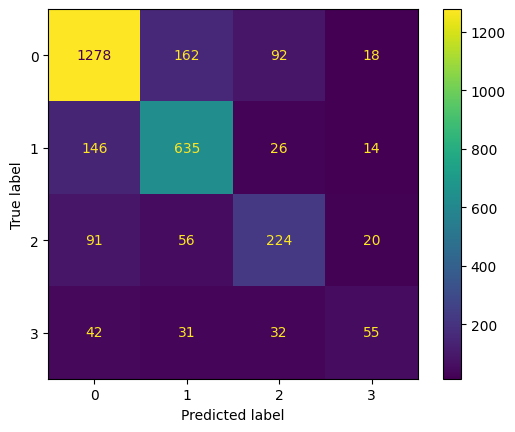

In [42]:
# "informative": 1, "not_informative": 0
print(task + '_VGG16_pretrained Confusion Matrix:\n')
print('informative: 1, not_informative: 0')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()

# VGG16_scratch

In [43]:
model = models.vgg16(weights=None)
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, len(class_label_map))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
criterion = nn.CrossEntropyLoss()

train_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}

## Train

In [44]:
# Learning schedule update
def dev_one_epoch(dev_data_loader):
    epoch_loss = []
    epoch_acc = []

    model.eval()

    with torch.no_grad():
        for images, labels in dev_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)  # Forward

            # Calculating Loss
            _loss = criterion(preds, labels)
            loss = _loss.item()
            epoch_loss.append(loss)

            # Calculating Accuracy
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            epoch_acc.append(acc)

    # Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)

    return epoch_loss, epoch_acc

In [45]:
def train_one_epoch(train_data_loader):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.train()

    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(images)

        # Calculating Loss
        loss = criterion(preds, labels)
        epoch_loss.append(loss.item())

        # Calculating Metrics
        _, predicts = preds.max(1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)
        f1 = f1_score(labels, predicts, average="weighted")
        epoch_acc.append(acc)
        epoch_f1.append(f1)
        trues.append(labels)
        prediction.append(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(accuracy)
    train_logs["acc"].append(epoch_acc) # check
    train_logs["f1"].append(epoch_f1) # check
    train_logs["f1-score"].append(f1score)
    train_logs["time"].append(total_time)

    return epoch_loss, accuracy, f1score, total_time

def val_one_epoch(val_data_loader, best_val_acc):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculating Metrics
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            f1 = f1_score(labels, predicts, average="weighted")
            epoch_acc.append(acc)
            epoch_f1.append(f1)
            trues.append(labels)
            prediction.append(predicts)
   
    
    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    cm = confusion_matrix(trues, prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100
    cr = classification_report(trues, prediction)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(accuracy)
    val_logs["acc"].append(epoch_acc) # check
    val_logs["f1"].append(epoch_f1) # check
    val_logs["f1-score"].append(f1score)
    val_logs["time"].append(total_time)

    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), task + "_VGG16_scratch.pth")

    return epoch_loss, accuracy, f1score, total_time, best_val_acc, cm, cr

In [46]:
best_val_acc = 0
best_val_f1 = 0

for epoch in range(epochs):
    train_loss, train_acc, train_f1, train_time = train_one_epoch(trainloader) # Training
    dev_loss, dev_acc = dev_one_epoch(devloader) # Dev
    lr_scheduler.step(dev_loss)
    val_loss, val_acc, val_f1, val_time, best_val_acc, cm, cr = val_one_epoch(testloader, best_val_acc) # Validation

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1

    total_time = train_time + val_time
    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.2f}% - time: {total_time:.2f}s")

Epoch 1/5 - loss: 1.1222 - accuracy: 51.17% - val_loss: 1.0281 - val_accuracy: 57.05% - time: 178.05s
Epoch 2/5 - loss: 1.0608 - accuracy: 56.54% - val_loss: 1.0084 - val_accuracy: 58.56% - time: 173.77s
Epoch 3/5 - loss: 1.0260 - accuracy: 58.50% - val_loss: 0.9972 - val_accuracy: 59.82% - time: 175.78s
Epoch 4/5 - loss: 0.9985 - accuracy: 59.07% - val_loss: 0.9729 - val_accuracy: 59.65% - time: 179.24s
Epoch 5/5 - loss: 0.9676 - accuracy: 60.81% - val_loss: 0.9697 - val_accuracy: 60.85% - time: 183.02s


In [47]:
print(task + '_VGG16_scratch Performance:')
print(f'Accuracy : {best_val_acc:.2f}%')
print(f'F1-Score : {best_val_f1:.2f}%')
print(task + '_VGG16_scratch Classification Report:')
print(cr)

Humanitarian_Classification_VGG16_scratch Performance:
Accuracy : 61.07%
F1-Score : 57.30%
Humanitarian_Classification_VGG16_scratch Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.82      0.73      1550
           1       0.57      0.54      0.55       821
           2       0.30      0.17      0.22       391
           3       0.00      0.00      0.00       160

    accuracy                           0.61      2922
   macro avg       0.38      0.38      0.38      2922
weighted avg       0.55      0.61      0.57      2922



## Visualize Results & Confusion Matrix

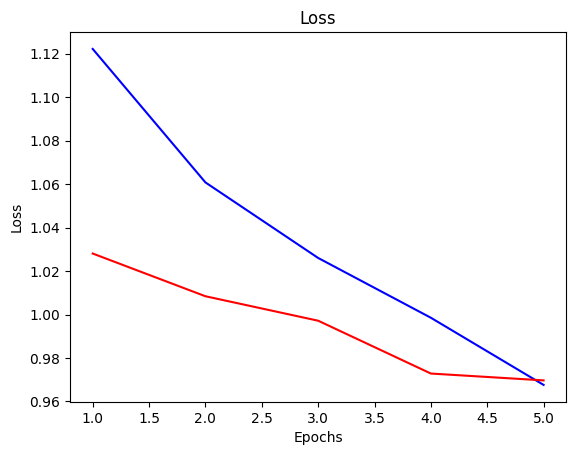

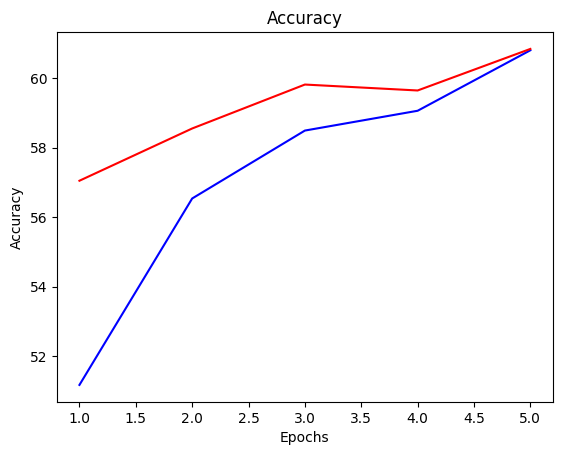

In [48]:
# Loss
plt.title("Loss")
plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Humanitarian_Classification_VGG16_scratch Confusion Matrix:

affected_injured_or_dead_people: 3, rescue_volunteering_or_donation_effort: 2, infrastructure_and_utility_damage: 1, not_humanitarian: 0


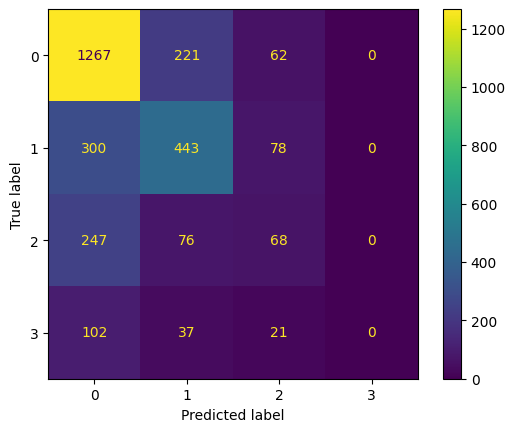

In [49]:
# "informative": 1, "not_informative": 0
print(task + '_VGG16_scratch Confusion Matrix:\n')
print('informative: 1, not_informative: 0')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()

# ResNet18_pretrained

In [50]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_label_map))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
criterion = nn.CrossEntropyLoss()

train_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}

## Train

In [51]:
# Learning schedule update
def dev_one_epoch(dev_data_loader):
    epoch_loss = []
    epoch_acc = []

    model.eval()

    with torch.no_grad():
        for images, labels in dev_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)  # Forward

            # Calculating Loss
            _loss = criterion(preds, labels)
            loss = _loss.item()
            epoch_loss.append(loss)

            # Calculating Accuracy
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            epoch_acc.append(acc)

    # Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)

    return epoch_loss, epoch_acc

In [52]:
def train_one_epoch(train_data_loader):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.train()

    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(images)

        # Calculating Loss
        loss = criterion(preds, labels)
        epoch_loss.append(loss.item())

        # Calculating Metrics
        _, predicts = preds.max(1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)
        f1 = f1_score(labels, predicts, average="weighted")
        epoch_acc.append(acc)
        epoch_f1.append(f1)
        trues.append(labels)
        prediction.append(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(accuracy)
    train_logs["acc"].append(epoch_acc) # check
    train_logs["f1"].append(epoch_f1) # check
    train_logs["f1-score"].append(f1score)
    train_logs["time"].append(total_time)

    return epoch_loss, accuracy, f1score, total_time

def val_one_epoch(val_data_loader, best_val_acc):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculating Metrics
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            f1 = f1_score(labels, predicts, average="weighted")
            epoch_acc.append(acc)
            epoch_f1.append(f1)
            trues.append(labels)
            prediction.append(predicts)
   
    
    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    cm = confusion_matrix(trues, prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100
    cr = classification_report(trues, prediction)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(accuracy)
    val_logs["acc"].append(epoch_acc) # check
    val_logs["f1"].append(epoch_f1) # check
    val_logs["f1-score"].append(f1score)
    val_logs["time"].append(total_time)

    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), task + "_ResNet18_pretrained.pth")

    return epoch_loss, accuracy, f1score, total_time, best_val_acc, cm, cr

In [53]:
best_val_acc = 0
best_val_f1 = 0

for epoch in range(epochs):
    train_loss, train_acc, train_f1, train_time = train_one_epoch(trainloader) # Training
    dev_loss, dev_acc = dev_one_epoch(devloader) # Dev
    lr_scheduler.step(dev_loss)
    val_loss, val_acc, val_f1, val_time, best_val_acc, cm, cr = val_one_epoch(testloader, best_val_acc) # Validation

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1

    total_time = train_time + val_time
    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.2f}% - time: {total_time:.2f}s")

Epoch 1/5 - loss: 0.8609 - accuracy: 65.95% - val_loss: 0.7140 - val_accuracy: 71.29% - time: 42.84s
Epoch 2/5 - loss: 0.6066 - accuracy: 76.57% - val_loss: 0.6675 - val_accuracy: 73.96% - time: 45.79s
Epoch 3/5 - loss: 0.4974 - accuracy: 81.23% - val_loss: 0.6638 - val_accuracy: 74.26% - time: 42.72s
Epoch 4/5 - loss: 0.4095 - accuracy: 85.00% - val_loss: 0.6648 - val_accuracy: 74.33% - time: 40.94s
Epoch 5/5 - loss: 0.3250 - accuracy: 88.89% - val_loss: 0.6882 - val_accuracy: 74.20% - time: 41.30s


In [54]:
print(task + '_ResNet18_pretrained Performance:')
print(f'Accuracy : {best_val_acc:.2f}%')
print(f'F1-Score : {best_val_f1:.2f}%')
print(task + '_ResNet18_pretrained Classification Report:')
print(cr)

Humanitarian_Classification_ResNet18_pretrained Performance:
Accuracy : 74.45%
F1-Score : 73.76%
Humanitarian_Classification_ResNet18_pretrained Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.84      0.83      1550
           1       0.71      0.73      0.72       821
           2       0.60      0.53      0.56       391
           3       0.45      0.34      0.39       160

    accuracy                           0.74      2922
   macro avg       0.64      0.61      0.62      2922
weighted avg       0.73      0.74      0.74      2922



## Visualize Results & Confusion Matrix

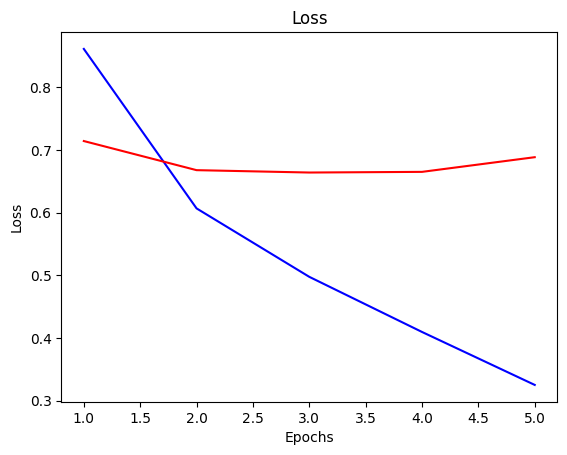

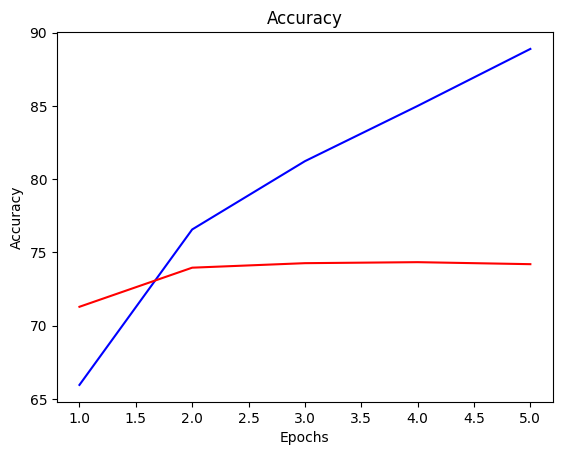

In [55]:
# Loss
plt.title("Loss")
plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Humanitarian_Classification_ResNet18_pretrained Confusion Matrix:

affected_injured_or_dead_people: 3, rescue_volunteering_or_donation_effort: 2, infrastructure_and_utility_damage: 1, not_humanitarian: 0


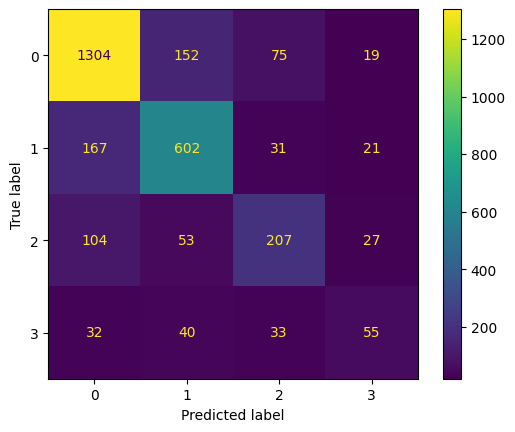

In [56]:
# "informative": 1, "not_informative": 0
print(task + '_ResNet18_pretrained Confusion Matrix:\n')
print('informative: 1, not_informative: 0')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()

# ResNet18_scratch

In [57]:
model = models.resnet18(weights=None)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_label_map))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
criterion = nn.CrossEntropyLoss()

train_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}

## Train

In [58]:
# Learning schedule update
def dev_one_epoch(dev_data_loader):
    epoch_loss = []
    epoch_acc = []

    model.eval()

    with torch.no_grad():
        for images, labels in dev_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)  # Forward

            # Calculating Loss
            _loss = criterion(preds, labels)
            loss = _loss.item()
            epoch_loss.append(loss)

            # Calculating Accuracy
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            epoch_acc.append(acc)

    # Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)

    return epoch_loss, epoch_acc

In [59]:
def train_one_epoch(train_data_loader):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.train()

    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(images)

        # Calculating Loss
        loss = criterion(preds, labels)
        epoch_loss.append(loss.item())

        # Calculating Metrics
        _, predicts = preds.max(1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)
        f1 = f1_score(labels, predicts, average="weighted")
        epoch_acc.append(acc)
        epoch_f1.append(f1)
        trues.append(labels)
        prediction.append(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(accuracy)
    train_logs["acc"].append(epoch_acc) # check
    train_logs["f1"].append(epoch_f1) # check
    train_logs["f1-score"].append(f1score)
    train_logs["time"].append(total_time)

    return epoch_loss, accuracy, f1score, total_time

def val_one_epoch(val_data_loader, best_val_acc):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculating Metrics
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            f1 = f1_score(labels, predicts, average="weighted")
            epoch_acc.append(acc)
            epoch_f1.append(f1)
            trues.append(labels)
            prediction.append(predicts)
   
    
    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    cm = confusion_matrix(trues, prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100
    cr = classification_report(trues, prediction)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(accuracy)
    val_logs["acc"].append(epoch_acc) # check
    val_logs["f1"].append(epoch_f1) # check
    val_logs["f1-score"].append(f1score)
    val_logs["time"].append(total_time)

    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), task + "_ResNet18_scratch.pth")

    return epoch_loss, accuracy, f1score, total_time, best_val_acc, cm, cr

In [60]:
best_val_acc = 0
best_val_f1 = 0

for epoch in range(epochs):
    train_loss, train_acc, train_f1, train_time = train_one_epoch(trainloader) # Training
    dev_loss, dev_acc = dev_one_epoch(devloader) # Dev
    lr_scheduler.step(dev_loss)
    val_loss, val_acc, val_f1, val_time, best_val_acc, cm, cr = val_one_epoch(testloader, best_val_acc) # Validation

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1

    total_time = train_time + val_time
    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.2f}% - time: {total_time:.2f}s")

Epoch 1/5 - loss: 1.1691 - accuracy: 50.32% - val_loss: 1.0533 - val_accuracy: 56.64% - time: 41.61s
Epoch 2/5 - loss: 0.9804 - accuracy: 59.81% - val_loss: 0.9947 - val_accuracy: 58.66% - time: 41.00s
Epoch 3/5 - loss: 0.9190 - accuracy: 62.46% - val_loss: 0.9528 - val_accuracy: 60.13% - time: 42.02s
Epoch 4/5 - loss: 0.8603 - accuracy: 65.33% - val_loss: 0.9929 - val_accuracy: 59.10% - time: 41.69s
Epoch 5/5 - loss: 0.7847 - accuracy: 69.38% - val_loss: 1.1124 - val_accuracy: 55.51% - time: 40.58s


In [61]:
print(task + '_ResNet18_scratch Performance:')
print(f'Accuracy : {best_val_acc:.2f}%')
print(f'F1-Score : {best_val_f1:.2f}%')
print(task + '_ResNet18_scratch Classification Report:')
print(cr)

Humanitarian_Classification_ResNet18_scratch Performance:
Accuracy : 60.43%
F1-Score : 57.42%
Humanitarian_Classification_ResNet18_scratch Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.57      0.64      1550
           1       0.45      0.79      0.57       821
           2       0.32      0.22      0.26       391
           3       0.80      0.03      0.05       160

    accuracy                           0.56      2922
   macro avg       0.58      0.40      0.38      2922
weighted avg       0.60      0.56      0.54      2922



## Visualize Results & Confusion Matrix

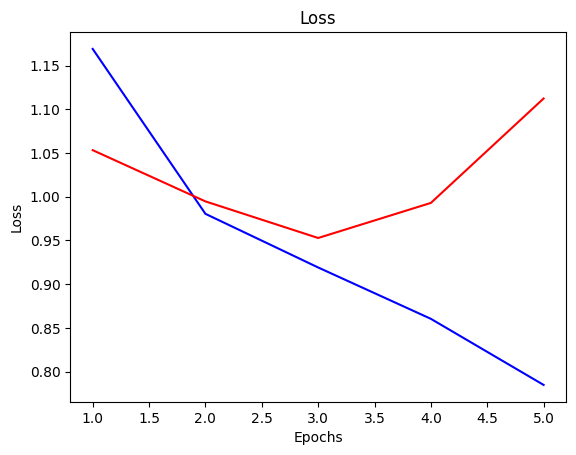

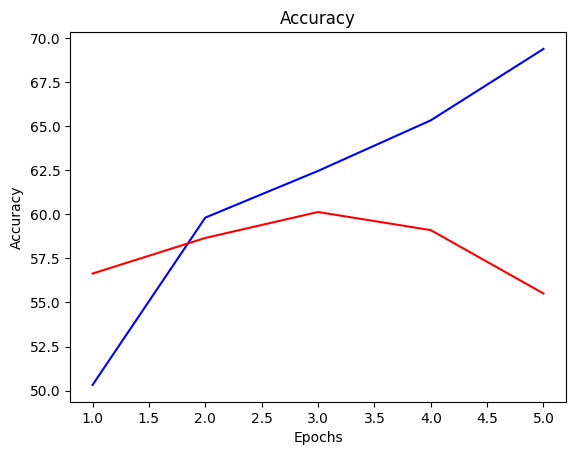

In [62]:
# Loss
plt.title("Loss")
plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Humanitarian_Classification_ResNet18_scratch Confusion Matrix:

affected_injured_or_dead_people: 3, rescue_volunteering_or_donation_effort: 2, infrastructure_and_utility_damage: 1, not_humanitarian: 0


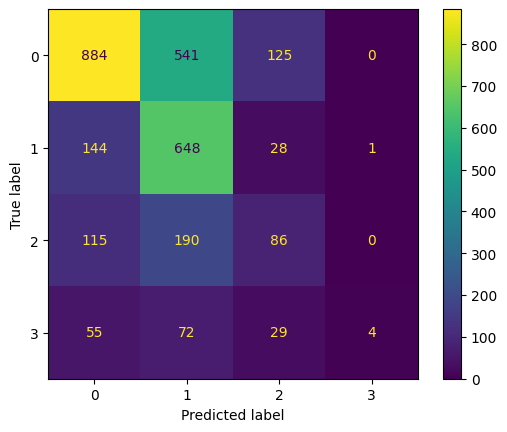

In [63]:
# "informative": 1, "not_informative": 0
print(task + '_ResNet18_scratch Confusion Matrix:\n')
print('informative: 1, not_informative: 0')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()

# ResNet101_pretrained

In [64]:
model = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_label_map))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
criterion = nn.CrossEntropyLoss()

train_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}

## Train

In [65]:
# Learning schedule update
def dev_one_epoch(dev_data_loader):
    epoch_loss = []
    epoch_acc = []

    model.eval()

    with torch.no_grad():
        for images, labels in dev_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)  # Forward

            # Calculating Loss
            _loss = criterion(preds, labels)
            loss = _loss.item()
            epoch_loss.append(loss)

            # Calculating Accuracy
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            epoch_acc.append(acc)

    # Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)

    return epoch_loss, epoch_acc

In [66]:
def train_one_epoch(train_data_loader):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.train()

    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(images)

        # Calculating Loss
        loss = criterion(preds, labels)
        epoch_loss.append(loss.item())

        # Calculating Metrics
        _, predicts = preds.max(1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)
        f1 = f1_score(labels, predicts, average="weighted")
        epoch_acc.append(acc)
        epoch_f1.append(f1)
        trues.append(labels)
        prediction.append(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(accuracy)
    train_logs["acc"].append(epoch_acc) # check
    train_logs["f1"].append(epoch_f1) # check
    train_logs["f1-score"].append(f1score)
    train_logs["time"].append(total_time)

    return epoch_loss, accuracy, f1score, total_time

def val_one_epoch(val_data_loader, best_val_acc):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculating Metrics
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            f1 = f1_score(labels, predicts, average="weighted")
            epoch_acc.append(acc)
            epoch_f1.append(f1)
            trues.append(labels)
            prediction.append(predicts)
   
    
    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    cm = confusion_matrix(trues, prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100
    cr = classification_report(trues, prediction)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(accuracy)
    val_logs["acc"].append(epoch_acc) # check
    val_logs["f1"].append(epoch_f1) # check
    val_logs["f1-score"].append(f1score)
    val_logs["time"].append(total_time)

    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), task + "_ResNet101_pretrained.pth")

    return epoch_loss, accuracy, f1score, total_time, best_val_acc, cm, cr

In [67]:
best_val_acc = 0
best_val_f1 = 0

for epoch in range(epochs):
    train_loss, train_acc, train_f1, train_time = train_one_epoch(trainloader) # Training
    dev_loss, dev_acc = dev_one_epoch(devloader) # Dev
    lr_scheduler.step(dev_loss)
    val_loss, val_acc, val_f1, val_time, best_val_acc, cm, cr = val_one_epoch(testloader, best_val_acc) # Validation

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1

    total_time = train_time + val_time
    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.2f}% - time: {total_time:.2f}s")

Epoch 1/5 - loss: 0.9857 - accuracy: 61.90% - val_loss: 0.7670 - val_accuracy: 71.63% - time: 142.71s
Epoch 2/5 - loss: 0.6391 - accuracy: 75.67% - val_loss: 0.6318 - val_accuracy: 75.74% - time: 142.48s
Epoch 3/5 - loss: 0.4919 - accuracy: 81.53% - val_loss: 0.5919 - val_accuracy: 77.65% - time: 143.38s
Epoch 4/5 - loss: 0.3889 - accuracy: 85.52% - val_loss: 0.6040 - val_accuracy: 77.48% - time: 141.30s
Epoch 5/5 - loss: 0.2903 - accuracy: 89.60% - val_loss: 0.6221 - val_accuracy: 77.62% - time: 137.37s


In [68]:
print(task + '_ResNet101_pretrained Performance:')
print(f'Accuracy : {best_val_acc:.2f}%')
print(f'F1-Score : {best_val_f1:.2f}%')
print(task + '_ResNet101_pretrained Classification Report:')
print(cr)

Humanitarian_Classification_ResNet101_pretrained Performance:
Accuracy : 77.82%
F1-Score : 77.19%
Humanitarian_Classification_ResNet101_pretrained Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.87      0.84      1550
           1       0.76      0.76      0.76       821
           2       0.66      0.58      0.62       391
           3       0.60      0.44      0.51       160

    accuracy                           0.78      2922
   macro avg       0.71      0.66      0.68      2922
weighted avg       0.77      0.78      0.77      2922



## Visualize Results & Confusion Matrix

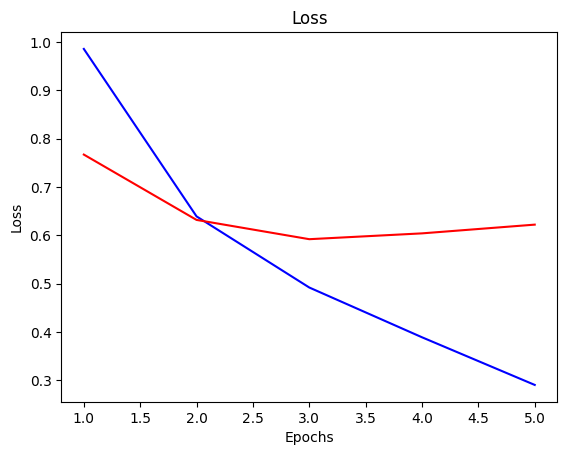

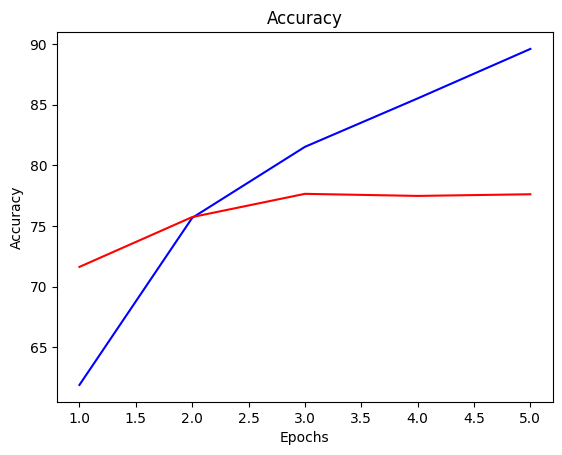

In [69]:
# Loss
plt.title("Loss")
plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Humanitarian_Classification_ResNet101_pretrained Confusion Matrix:

affected_injured_or_dead_people: 3, rescue_volunteering_or_donation_effort: 2, infrastructure_and_utility_damage: 1, not_humanitarian: 0


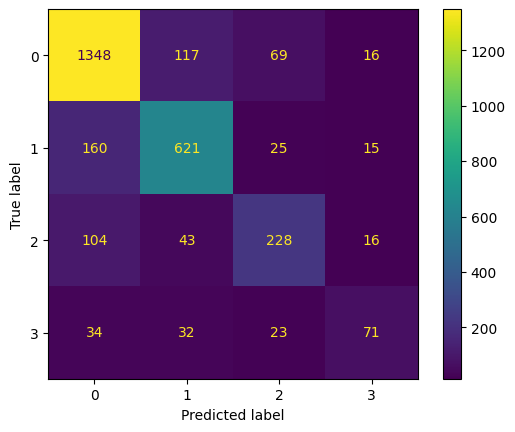

In [70]:
# "informative": 1, "not_informative": 0
print(task + '_ResNet101_pretrained Confusion Matrix:\n')
print('informative: 1, not_informative: 0')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()

# ResNet101_scratch

In [71]:
model = models.resnet101(weights=None)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_label_map))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
criterion = nn.CrossEntropyLoss()

train_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}

## Train

In [72]:
# Learning schedule update
def dev_one_epoch(dev_data_loader):
    epoch_loss = []
    epoch_acc = []

    model.eval()

    with torch.no_grad():
        for images, labels in dev_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)  # Forward

            # Calculating Loss
            _loss = criterion(preds, labels)
            loss = _loss.item()
            epoch_loss.append(loss)

            # Calculating Accuracy
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            epoch_acc.append(acc)

    # Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)

    return epoch_loss, epoch_acc

In [73]:
def train_one_epoch(train_data_loader):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.train()

    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(images)

        # Calculating Loss
        loss = criterion(preds, labels)
        epoch_loss.append(loss.item())

        # Calculating Metrics
        _, predicts = preds.max(1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)
        f1 = f1_score(labels, predicts, average="weighted")
        epoch_acc.append(acc)
        epoch_f1.append(f1)
        trues.append(labels)
        prediction.append(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(accuracy)
    train_logs["acc"].append(epoch_acc) # check
    train_logs["f1"].append(epoch_f1) # check
    train_logs["f1-score"].append(f1score)
    train_logs["time"].append(total_time)

    return epoch_loss, accuracy, f1score, total_time

def val_one_epoch(val_data_loader, best_val_acc):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculating Metrics
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            f1 = f1_score(labels, predicts, average="weighted")
            epoch_acc.append(acc)
            epoch_f1.append(f1)
            trues.append(labels)
            prediction.append(predicts)
   
    
    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    cm = confusion_matrix(trues, prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100
    cr = classification_report(trues, prediction)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(accuracy)
    val_logs["acc"].append(epoch_acc) # check
    val_logs["f1"].append(epoch_f1) # check
    val_logs["f1-score"].append(f1score)
    val_logs["time"].append(total_time)

    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), task + "_ResNet101_scratch.pth")

    return epoch_loss, accuracy, f1score, total_time, best_val_acc, cm, cr

In [74]:
best_val_acc = 0
best_val_f1 = 0

for epoch in range(epochs):
    train_loss, train_acc, train_f1, train_time = train_one_epoch(trainloader) # Training
    dev_loss, dev_acc = dev_one_epoch(devloader) # Dev
    lr_scheduler.step(dev_loss)
    val_loss, val_acc, val_f1, val_time, best_val_acc, cm, cr = val_one_epoch(testloader, best_val_acc) # Validation

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1

    total_time = train_time + val_time
    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.2f}% - time: {total_time:.2f}s")

Epoch 1/5 - loss: 1.1559 - accuracy: 47.74% - val_loss: 1.1136 - val_accuracy: 52.40% - time: 137.68s
Epoch 2/5 - loss: 1.1178 - accuracy: 50.37% - val_loss: 1.0786 - val_accuracy: 54.76% - time: 136.40s
Epoch 3/5 - loss: 1.0841 - accuracy: 53.61% - val_loss: 1.0609 - val_accuracy: 56.33% - time: 136.67s
Epoch 4/5 - loss: 1.0722 - accuracy: 54.52% - val_loss: 1.0560 - val_accuracy: 55.72% - time: 143.36s
Epoch 5/5 - loss: 1.0623 - accuracy: 54.94% - val_loss: 1.1065 - val_accuracy: 51.44% - time: 142.48s


In [75]:
print(task + '_ResNet101_scratch Performance:')
print(f'Accuracy : {best_val_acc:.2f}%')
print(f'F1-Score : {best_val_f1:.2f}%')
print(task + '_ResNet101_scratch Classification Report:')
print(cr)

Humanitarian_Classification_ResNet101_scratch Performance:
Accuracy : 56.51%
F1-Score : 50.34%
Humanitarian_Classification_ResNet101_scratch Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.58      0.63      1550
           1       0.37      0.73      0.49       821
           2       0.00      0.00      0.00       391
           3       0.00      0.00      0.00       160

    accuracy                           0.51      2922
   macro avg       0.27      0.33      0.28      2922
weighted avg       0.47      0.51      0.47      2922



## Visualize Results & Confusion Matrix

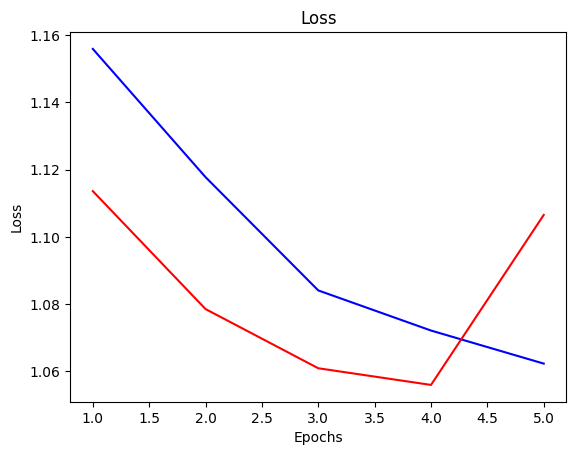

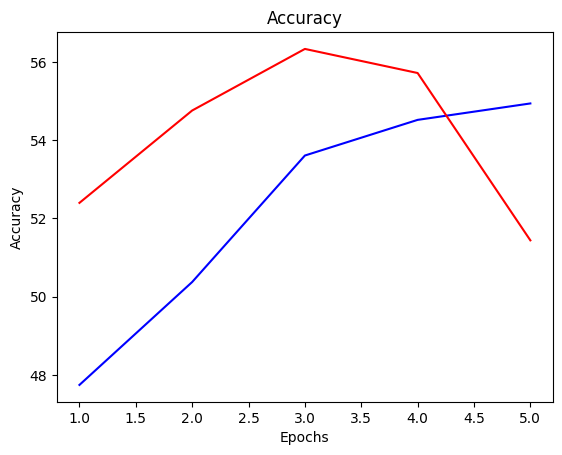

In [76]:
# Loss
plt.title("Loss")
plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Humanitarian_Classification_ResNet101_scratch Confusion Matrix:

affected_injured_or_dead_people: 3, rescue_volunteering_or_donation_effort: 2, infrastructure_and_utility_damage: 1, not_humanitarian: 0


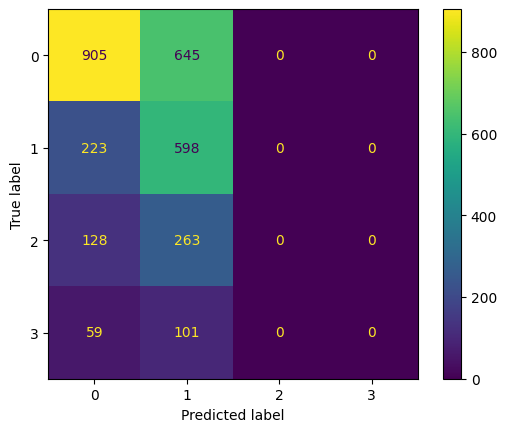

In [77]:
# "informative": 1, "not_informative": 0
print(task + '_ResNet101_scratch Confusion Matrix:\n')
print('informative: 1, not_informative: 0')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()

# DenseNet121_pretrained

In [78]:
model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, len(class_label_map))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
criterion = nn.CrossEntropyLoss()

train_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}

## Train

In [79]:
# Learning schedule update
def dev_one_epoch(dev_data_loader):
    epoch_loss = []
    epoch_acc = []

    model.eval()

    with torch.no_grad():
        for images, labels in dev_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)  # Forward

            # Calculating Loss
            _loss = criterion(preds, labels)
            loss = _loss.item()
            epoch_loss.append(loss)

            # Calculating Accuracy
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            epoch_acc.append(acc)

    # Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)

    return epoch_loss, epoch_acc

In [80]:
def train_one_epoch(train_data_loader):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.train()

    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(images)

        # Calculating Loss
        loss = criterion(preds, labels)
        epoch_loss.append(loss.item())

        # Calculating Metrics
        _, predicts = preds.max(1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)
        f1 = f1_score(labels, predicts, average="weighted")
        epoch_acc.append(acc)
        epoch_f1.append(f1)
        trues.append(labels)
        prediction.append(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(accuracy)
    train_logs["acc"].append(epoch_acc) # check
    train_logs["f1"].append(epoch_f1) # check
    train_logs["f1-score"].append(f1score)
    train_logs["time"].append(total_time)

    return epoch_loss, accuracy, f1score, total_time

def val_one_epoch(val_data_loader, best_val_acc):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculating Metrics
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            f1 = f1_score(labels, predicts, average="weighted")
            epoch_acc.append(acc)
            epoch_f1.append(f1)
            trues.append(labels)
            prediction.append(predicts)
   
    
    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    cm = confusion_matrix(trues, prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100
    cr = classification_report(trues, prediction)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(accuracy)
    val_logs["acc"].append(epoch_acc) # check
    val_logs["f1"].append(epoch_f1) # check
    val_logs["f1-score"].append(f1score)
    val_logs["time"].append(total_time)

    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), task + "_DenseNet121_pretrained.pth")

    return epoch_loss, accuracy, f1score, total_time, best_val_acc, cm, cr

In [81]:
best_val_acc = 0
best_val_f1 = 0

for epoch in range(epochs):
    train_loss, train_acc, train_f1, train_time = train_one_epoch(trainloader) # Training
    dev_loss, dev_acc = dev_one_epoch(devloader) # Dev
    lr_scheduler.step(dev_loss)
    val_loss, val_acc, val_f1, val_time, best_val_acc, cm, cr = val_one_epoch(testloader, best_val_acc) # Validation

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1

    total_time = train_time + val_time
    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.2f}% - time: {total_time:.2f}s")

Epoch 1/5 - loss: 0.9105 - accuracy: 64.84% - val_loss: 0.7275 - val_accuracy: 71.53% - time: 107.17s
Epoch 2/5 - loss: 0.6296 - accuracy: 75.92% - val_loss: 0.6549 - val_accuracy: 74.44% - time: 106.33s
Epoch 3/5 - loss: 0.5405 - accuracy: 79.67% - val_loss: 0.6299 - val_accuracy: 74.57% - time: 105.20s
Epoch 4/5 - loss: 0.4642 - accuracy: 83.36% - val_loss: 0.6273 - val_accuracy: 75.77% - time: 99.29s
Epoch 5/5 - loss: 0.3885 - accuracy: 86.32% - val_loss: 0.6259 - val_accuracy: 75.50% - time: 100.36s


In [82]:
print(task + '_DenseNet121_pretrained Performance:')
print(f'Accuracy : {best_val_acc:.2f}%')
print(f'F1-Score : {best_val_f1:.2f}%')
print(task + '_DenseNet121_pretrained Classification Report:')
print(cr)

Humanitarian_Classification_DenseNet121_pretrained Performance:
Accuracy : 75.95%
F1-Score : 74.86%
Humanitarian_Classification_DenseNet121_pretrained Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.85      0.83      1550
           1       0.72      0.77      0.75       821
           2       0.60      0.55      0.57       391
           3       0.57      0.25      0.35       160

    accuracy                           0.75      2922
   macro avg       0.68      0.61      0.63      2922
weighted avg       0.75      0.75      0.75      2922



## Visualize Results & Confusion Matrix

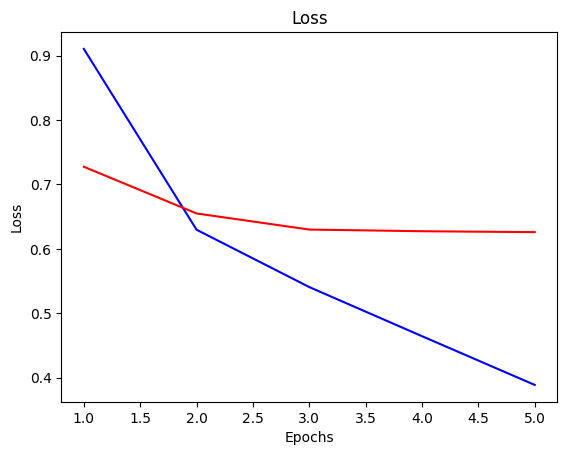

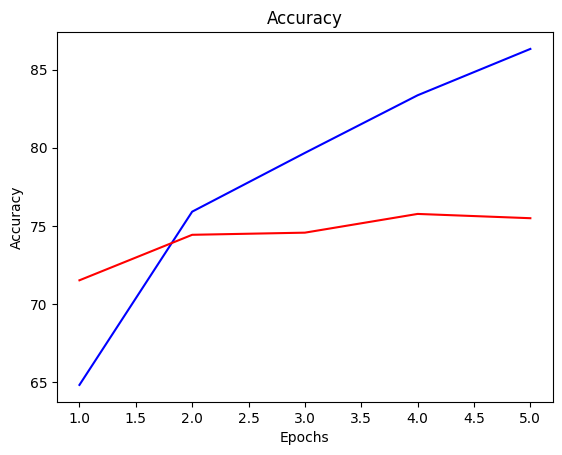

In [83]:
# Loss
plt.title("Loss")
plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Humanitarian_Classification_DenseNet121_pretrained Confusion Matrix:

affected_injured_or_dead_people: 3, rescue_volunteering_or_donation_effort: 2, infrastructure_and_utility_damage: 1, not_humanitarian: 0


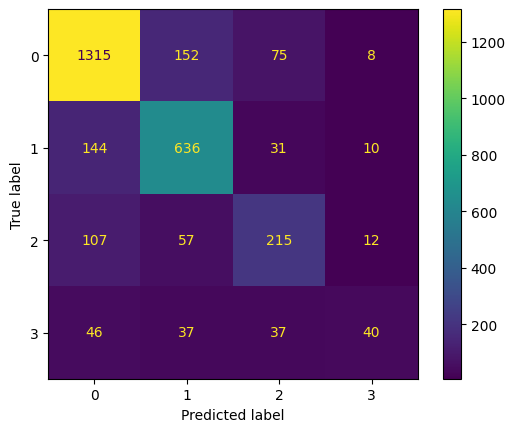

In [84]:
# "informative": 1, "not_informative": 0
print(task + '_DenseNet121_pretrained Confusion Matrix:\n')
print('informative: 1, not_informative: 0')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()

# DenseNet121_scratch

In [85]:
model = models.densenet121(weights=None)
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, len(class_label_map))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
criterion = nn.CrossEntropyLoss()

train_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}

## Train

In [86]:
# Learning schedule update
def dev_one_epoch(dev_data_loader):
    epoch_loss = []
    epoch_acc = []

    model.eval()

    with torch.no_grad():
        for images, labels in dev_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)  # Forward

            # Calculating Loss
            _loss = criterion(preds, labels)
            loss = _loss.item()
            epoch_loss.append(loss)

            # Calculating Accuracy
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            epoch_acc.append(acc)

    # Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)

    return epoch_loss, epoch_acc

In [87]:
def train_one_epoch(train_data_loader):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.train()

    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(images)

        # Calculating Loss
        loss = criterion(preds, labels)
        epoch_loss.append(loss.item())

        # Calculating Metrics
        _, predicts = preds.max(1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)
        f1 = f1_score(labels, predicts, average="weighted")
        epoch_acc.append(acc)
        epoch_f1.append(f1)
        trues.append(labels)
        prediction.append(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(accuracy)
    train_logs["acc"].append(epoch_acc) # check
    train_logs["f1"].append(epoch_f1) # check
    train_logs["f1-score"].append(f1score)
    train_logs["time"].append(total_time)

    return epoch_loss, accuracy, f1score, total_time

def val_one_epoch(val_data_loader, best_val_acc):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculating Metrics
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            f1 = f1_score(labels, predicts, average="weighted")
            epoch_acc.append(acc)
            epoch_f1.append(f1)
            trues.append(labels)
            prediction.append(predicts)
   
    
    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    cm = confusion_matrix(trues, prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100
    cr = classification_report(trues, prediction)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(accuracy)
    val_logs["acc"].append(epoch_acc) # check
    val_logs["f1"].append(epoch_f1) # check
    val_logs["f1-score"].append(f1score)
    val_logs["time"].append(total_time)

    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), task + "_DenseNet121_scratch.pth")

    return epoch_loss, accuracy, f1score, total_time, best_val_acc, cm, cr

In [88]:
best_val_acc = 0
best_val_f1 = 0

for epoch in range(epochs):
    train_loss, train_acc, train_f1, train_time = train_one_epoch(trainloader) # Training
    dev_loss, dev_acc = dev_one_epoch(devloader) # Dev
    lr_scheduler.step(dev_loss)
    val_loss, val_acc, val_f1, val_time, best_val_acc, cm, cr = val_one_epoch(testloader, best_val_acc) # Validation

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1

    total_time = train_time + val_time
    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.2f}% - time: {total_time:.2f}s")

Epoch 1/5 - loss: 1.1019 - accuracy: 54.02% - val_loss: 1.0119 - val_accuracy: 59.45% - time: 98.66s
Epoch 2/5 - loss: 0.9917 - accuracy: 58.95% - val_loss: 0.9933 - val_accuracy: 59.69% - time: 101.21s
Epoch 3/5 - loss: 0.9592 - accuracy: 60.34% - val_loss: 0.9525 - val_accuracy: 60.99% - time: 99.88s
Epoch 4/5 - loss: 0.9327 - accuracy: 61.23% - val_loss: 0.9396 - val_accuracy: 61.67% - time: 99.16s
Epoch 5/5 - loss: 0.9111 - accuracy: 62.41% - val_loss: 0.9368 - val_accuracy: 60.23% - time: 99.39s


In [89]:
print(task + '_DenseNet121_scratch Performance:')
print(f'Accuracy : {best_val_acc:.2f}%')
print(f'F1-Score : {best_val_f1:.2f}%')
print(task + '_DenseNet121_scratch Classification Report:')
print(cr)

Humanitarian_Classification_DenseNet121_scratch Performance:
Accuracy : 61.88%
F1-Score : 58.11%
Humanitarian_Classification_DenseNet121_scratch Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.75      0.71      1550
           1       0.51      0.66      0.58       821
           2       0.35      0.15      0.21       391
           3       0.00      0.00      0.00       160

    accuracy                           0.60      2922
   macro avg       0.39      0.39      0.37      2922
weighted avg       0.55      0.60      0.57      2922



## Visualize Results & Confusion Matrix

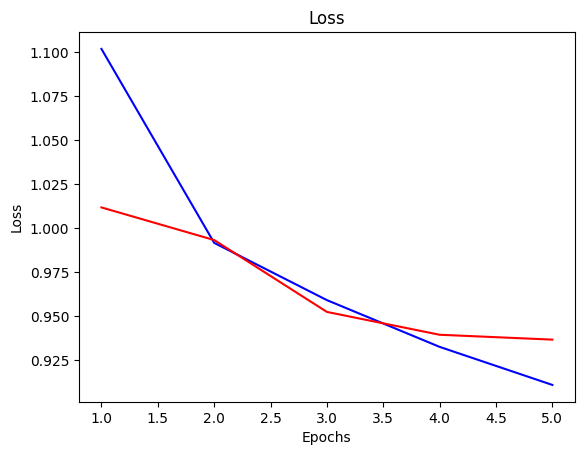

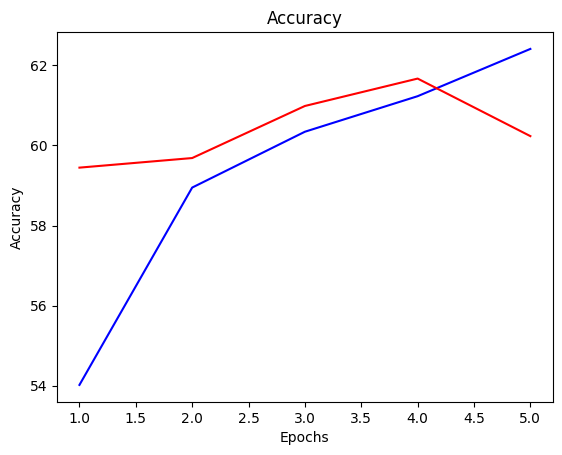

In [90]:
# Loss
plt.title("Loss")
plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Humanitarian_Classification_DenseNet121_scratch Confusion Matrix:

affected_injured_or_dead_people: 3, rescue_volunteering_or_donation_effort: 2, infrastructure_and_utility_damage: 1, not_humanitarian: 0


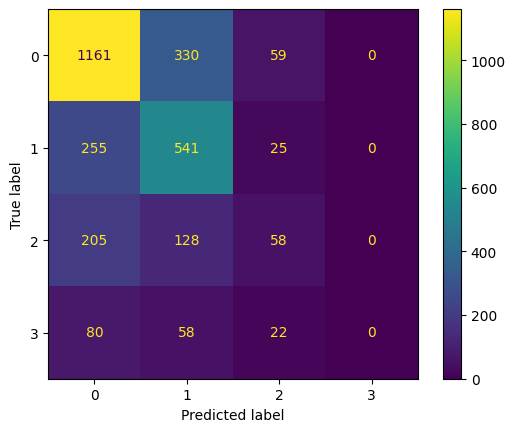

In [91]:
# "informative": 1, "not_informative": 0
print(task + '_DenseNet121_scratch Confusion Matrix:\n')
print('informative: 1, not_informative: 0')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()